In [5]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

AER
AEUR
RAND
AENR25
AENUR25
AENR50


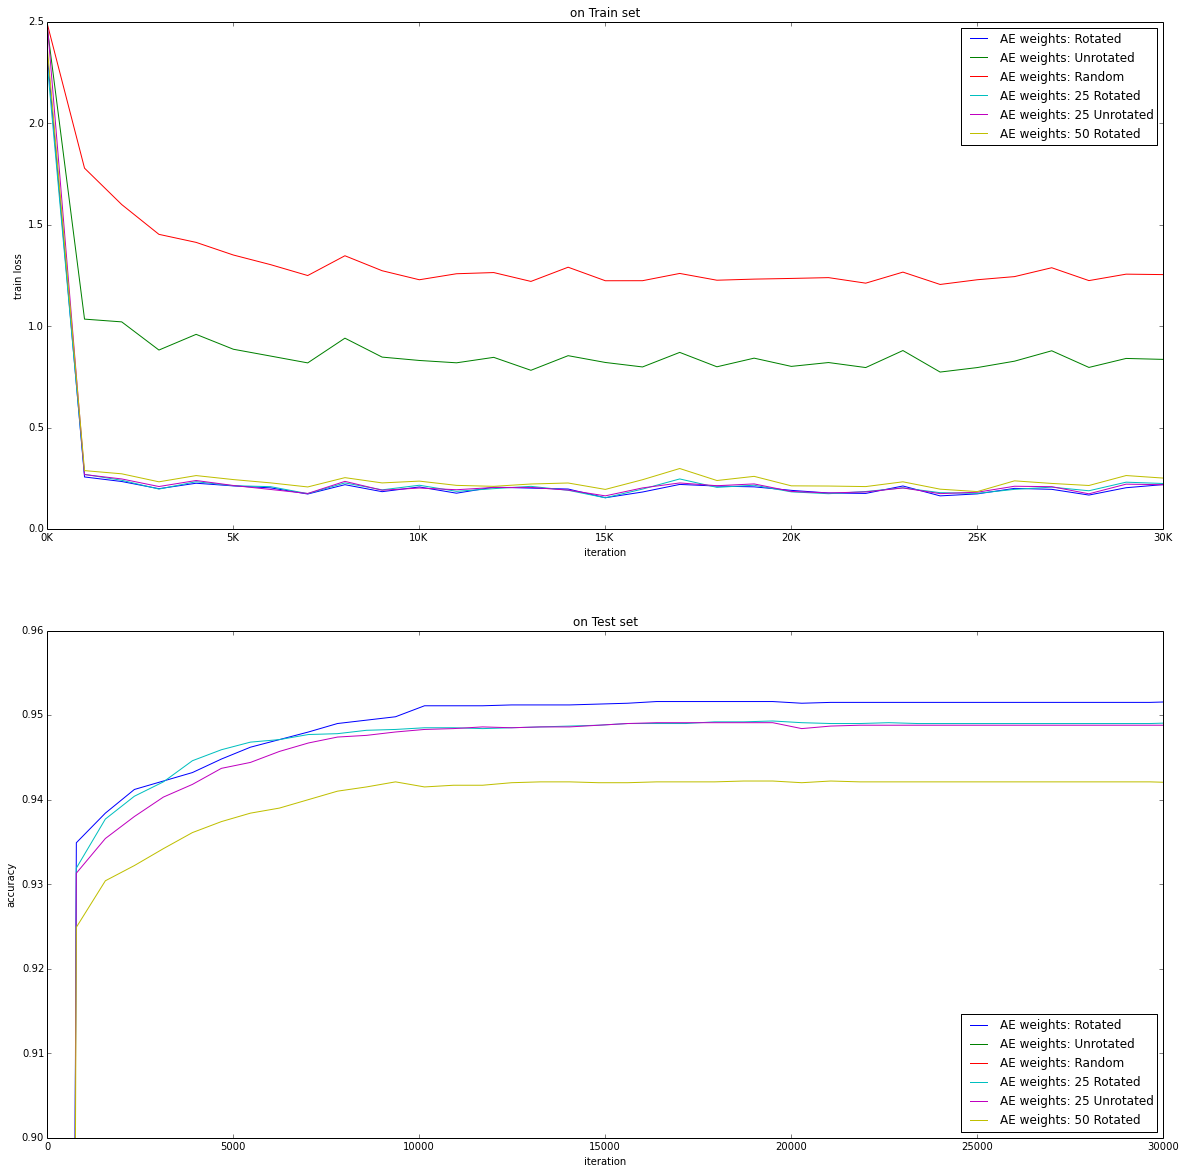

In [11]:
#exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50']
#exps = ['RAND', 'AENR25', 'AENUR25']

exp_labels = ['Rotated', 'Unrotated', 'Random', '25 Rotated', '25 Unrotated', '50 Rotated' ]#, '50 Unrotated']
exp_data = {'AER':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AER/log/log.log'} ,
            'AEUR':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AEUR/log/log.log'},
            'RAND':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/RAND/log/log.log'},
            'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AENR25/log/log.log'},
            'AENUR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AENUR25/log/log.log'},
            'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AENR50/log/log.log'},
            #'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/MLP/AENUR50/log/log.log'},
            }
for exp in exps:
    e = LearningCurve(exp_data[exp]['log'])
    e.parse()
    for phase in [Phase.TRAIN, Phase.TEST]:
        exp_data[exp][phase] = {}
        exp_data[exp][phase]['num_iter'] = e.list('NumIters', phase)
        exp_data[exp][phase]['loss'] = e.list('loss', phase)
        exp_data[exp][phase]['acc'] = e.list('accuracy', phase)

plt.figure(figsize=(20,20))
xmax = 30000
ymin = 0.9
ymax = 0.96
for i, exp in enumerate(exps):
    print(exp)
    plt.subplot(2,1,1)
    phase = Phase.TRAIN
    plt.plot(exp_data[exp][phase]['num_iter'], exp_data[exp][phase]['loss'], label='AE weights: %s' % (exp_labels[i],))
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train loss')
    plt.title("on %s set" % (phase,))
    plt.legend()
    
    phase = Phase.TEST
    plt.subplot(2,1,2)
    plt.plot(exp_data[exp][phase]['num_iter'],exp_data[exp][phase]['acc'], label='AE weights: %s' % (exp_labels[i],))
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("on %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

plt.show()
